# Foreword

This script presents an hydrological model based on the rational method, as documented by the Soil Conservation Service - Curve Number Method (SCS-CN method). It aims to compute flow hydrographs for different pluvial flood scenarios (function of the return period and the event duration), using as inputs the precipitation conditions, the topography and the soil characteristics.

**Source**: https://edepot.wur.nl/183157.

# Import packages

In [1]:
# Python packages
import geopandas as gpd
import pandas as pd
import numpy as np
from whitebox.whitebox_tools import WhiteboxTools
import os
import matplotlib.pyplot as plt
import contextily as cx
from bmi_topography import Topography
from osgeo import gdal
import rioxarray as rxr
import statistics
import xarray as xr
import rasterio as rio
from rasterio import features
import shutil
from sqlalchemy import create_engine, text
import psycopg2
from shapely.geometry import Polygon, box
from rasterio.io import MemoryFile
from matplotlib import colors, cm
import pyflwdir
import requests
import zipfile
import glob
import warnings
warnings.filterwarnings("ignore")

# Initialize WhiteBoxTools
wbt = WhiteboxTools()
wbt.set_whitebox_dir('C:/Users/alvar/anaconda3/Lib/site-packages/whitebox/WBT')

def wbt_print_callback(value):
    pass

wbt.set_default_callback(wbt_print_callback)

# Create directory to store temporary results

tmp_dir = 'C:/Users/alvar/Documents/GitHub/tmp'
os.makedirs(tmp_dir, exist_ok=True)

# Connect to PostGIS database

In [2]:
import psycopg2

# PostGIS DB credentials
dbname = "hh"
dbuser = "postgres"
dbpass = "postgres"
dbhost = "localhost"
dbport = "5432"

# Connect to the PostgreSQL server
conn = psycopg2.connect(dbname='postgres', user=dbuser, password=dbpass, host=dbhost, port=dbport)
conn.autocommit = True  # Enable autocommit to create a database

# Create a cursor object
cur = conn.cursor()

# Create the PostGIS database
cur.execute(f"CREATE DATABASE {dbname} WITH ENCODING 'UTF8';")

# Close the cursor and connection
cur.close()
conn.close()


DuplicateDatabase: la base de datos «hh» ya existe


In [ ]:
# PostGIS DB credentials
dbname = "hh"
dbuser = "postgres"
dbpass = "postgres"
dbhost = "localhost"
dbport = "5432"

# Create PostGIS database
cmd = f'createdb -E UTF8 {dbname}'
os.system(cmd)

# Create connection to created database
db_connection_url = 'postgresql://' + dbuser + ':' + dbpass + '@' + dbhost + ':' + dbport + '/' + dbname
con = create_engine(db_connection_url)

# Execute the SQL command to create the PostGIS extension
query = text("CREATE EXTENSION IF NOT EXISTS postgis;")
with con.connect() as connection:
    connection.execute(query)
    connection.commit()

# Functions

In [18]:
def compute_comp_hydrograph(interval, d_total, precip):
    
    df_runoff = pd.DataFrame()
    df_runoff['time'] = np.arange(0, d_total + interval, interval)
    df_runoff['cum_rainfall'] = np.arange(0, precip + precip / (len(df_runoff)-1), precip / (len(df_runoff)-1))
    df_runoff['cum_runoff'] = [0 if p < 0.2*S
                               else round((p - 0.2*S)**2/(p + 0.8*S),2)
                               for p in df_runoff['cum_rainfall']]
    df_runoff['int_runoff'] = np.hstack((0, np.diff(df_runoff['cum_runoff'])))

    x = np.asarray(df_uh_ref['t/Tp'])
    y = np.asarray(df_uh_ref['qt/qp'])

    df_uh = pd.DataFrame()
    df_uh['time'] = np.arange(0, d_total*5, interval)
    df_uh['unit_hydrograph'] = [round(np.interp(value, x, y) * qp, 2) for value in df_uh['time'] / Tp]

    for Q, (idx, item) in zip(df_runoff['int_runoff'][1:], enumerate(df_runoff['int_runoff'])):

        df_uh[round(Q, 2)] = 0
        df_uh[round(Q, 2)][idx:] = round(Q * df_uh['unit_hydrograph'], 2)[:(len(df_uh)-idx)]

    df_uh = df_uh.set_index('time').drop('unit_hydrograph', axis=1)
    df_uh['comp_hydrograph'] = df_uh.sum(axis=1)

    return df_uh

# Define outlet

In [20]:
# Define outlet where we would like to compute the flow hydrograph
outlet_lon = [6.35637] # Longitude (in degrees)
outlet_lat = [50.43200] # Latitude (in degrees)
df_outlet = pd.DataFrame({'longitude':outlet_lon, 'latitude':outlet_lat})
gdf_outlet = gpd.GeoDataFrame(data=df_outlet, geometry=gpd.points_from_xy(outlet_lon, outlet_lat), crs=4326)


# Define Area Of Interest (AOI)

Global basins of different dimensions can be downloaded from https://www.hydrosheds.org/products/hydrobasins. <br>
Global rivers can be downloaded from https://www.hydrosheds.org/products/hydrorivers.

In [38]:
urls = [
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_af_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_ar_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_as_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_au_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_eu_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_gr_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_na_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_sa_lev01-12_v1c.zip',
    'https://data.hydrosheds.org/file/hydrobasins/standard/hybas_si_lev01-12_v1c.zip'
]

for url in urls:

    # Download zipfile
    os.makedirs(f'{tmp_dir}/hydrobasins', exist_ok=True)
    response = requests.get(url)
    fn = f"{tmp_dir}/hydrobasins/{url.split('/')[-1]}"
    with open(fn, 'wb') as file:  # Change the filename as needed
        file.write(response.content)

    # Extract zipfile
    with zipfile.ZipFile(fn, 'r') as zip_ref:
        zip_ref.extractall(f'{tmp_dir}/hydrobasins')

    print(url)

https://data.hydrosheds.org/file/hydrobasins/standard/hybas_af_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_ar_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_as_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_au_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_eu_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_gr_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_na_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_sa_lev01-12_v1c.zip
https://data.hydrosheds.org/file/hydrobasins/standard/hybas_si_lev01-12_v1c.zip


In [49]:
gdf_list = [gpd.read_file(file) for file in files[:12]]
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))



In [22]:
hybas_level = 10
continent = 'eu'
query = f"""
WITH outlet AS ( SELECT (ST_SetSRID(ST_MakePoint({outlet_lon[0]}, {outlet_lat[0]}),4326)) AS pt)
SELECT hybas_id FROM hybas_{continent}_lev{hybas_level}_v1c AS watershed
CROSS JOIN outlet
WHERE ST_WITHIN(outlet.pt,watershed.geom);
"""

gpd.read_postgis(query, con, geom_col='pt')

OperationalError: (psycopg2.OperationalError) connection to server at "localhost" (::1), port 5432 failed: FATAL:  no existe la base de datos <<aprida>>

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [12]:
# Identify the HydroBASINS where the POI is located
hybas_level = 10
continent = 'eu'
query = f"""
select hybas_id, next_down, geom FROM hybas_{continent}_lev{hybas_level}_v1c;
"""
gdf_watersheds = gpd.GeoDataFrame.from_postgis(query, con) # Read global database of watersheds as GeoDataFrame

query = f"""
WITH outlet AS ( SELECT (ST_SetSRID(ST_MakePoint({outlet_lon[0]}, {outlet_lat[0]}),4326)) AS pt)
SELECT hybas_id FROM hybas_{continent}_lev{hybas_level}_v1c AS watershed
CROSS JOIN outlet
WHERE ST_WITHIN(outlet.pt,watershed.geom);
"""
conn = psycopg2.connect(host=dbhost, port=dbport, database=dbname, user=dbuser, password=dbpass)
cursor = conn.cursor()
cursor.execute(query)
data = cursor.fetchone()
hybas_id = data[0]
cursor.close()
conn.close()
print("Watershed ID: ", int(hybas_id))
gdf_watershed_sel = gdf_watersheds[gdf_watersheds.hybas_id==hybas_id]

Watershed ID:  2100415910


Text(215.95669884947864, 0.5, 'Latitude (degrees)')

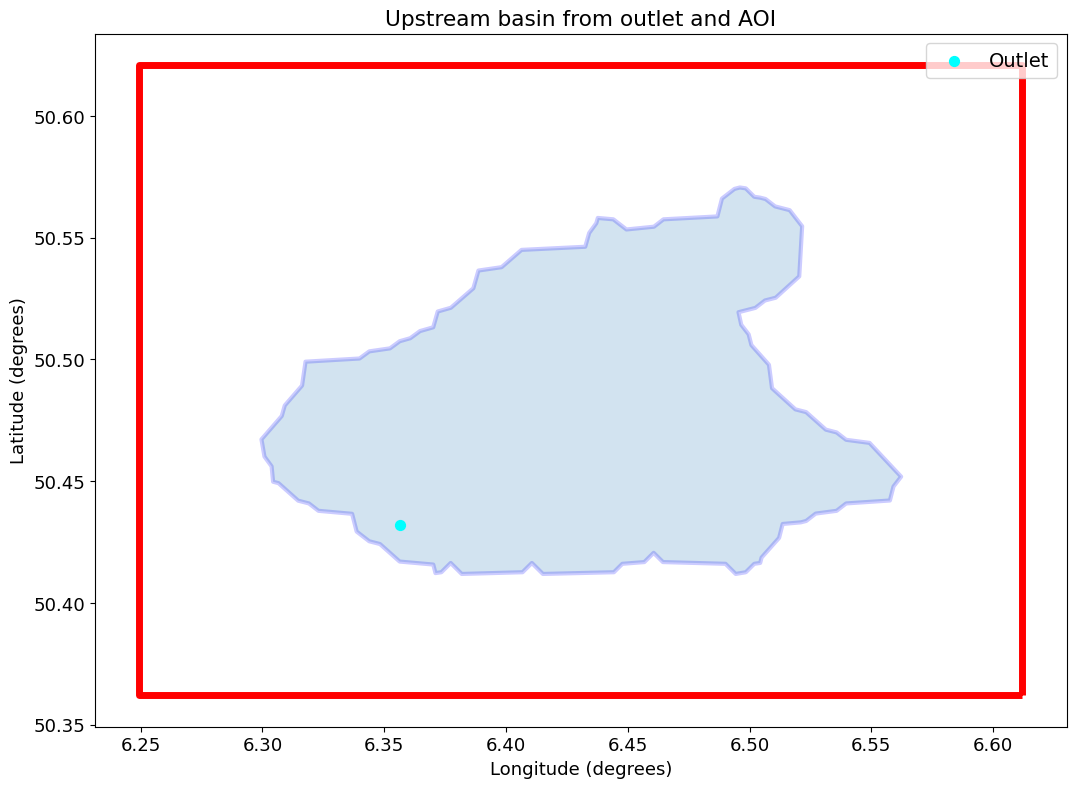

In [16]:
# Determine the upstream HydroBASINS from the outlet and disolve them
list_ids = [hybas_id]
while len(list_ids) > 0:  
    list_ids_new = []
    
    for ids in list_ids:

        gdf = gdf_watersheds[gdf_watersheds.next_down==ids]
        gdf_watershed_sel = pd.concat([gdf, gdf_watershed_sel], ignore_index=True)
        list_ids_new.append(list(gdf.hybas_id))

    list_ids = list(pd.DataFrame(list_ids_new).stack())

gdf_watershed_sel_dissolve = gdf_watershed_sel.dissolve()
gdf_watershed_sel_dissolve.to_file(os.path.join(temp_dir, 'US_basin.shp'))
bb_aoi_shp = gpd.GeoDataFrame(geometry=[box(*gdf_watershed_sel_dissolve.total_bounds)]).buffer(0.05, join_style=2)
bb_aoi_bounds = bb_aoi_shp.bounds

# Plot upstream basin from outlet
plt.rcParams['font.size'] = 13
fig, ax = plt.subplots(figsize=(15,9))
gdf_watershed_sel.plot(ax=ax, alpha=0.2, edgecolor='blue', linewidth=3)
gdf_outlet.plot(ax=ax, marker='o', color='cyan', markersize=50, label='Outlet')
bb_aoi_shp.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=5)
ax.legend(loc="upper right", fontsize=14)
# cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap)
ax.set_title(label="Upstream basin from outlet and AOI")
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

# Download DEM from OpenTopography API

Open Topography makes available the download of different global DEMs by means of its API. The API can be directly called from Pyhton using the bmi_topography package. <br>
More information on https://www.opentopography.org/.
Documentation in the following site: https://bmi-topography.readthedocs.io/en/latest/

In [11]:
params = Topography.DEFAULT.copy()
params["dem_type"] = "COP30"
params["south"] = bb_aoi_bounds['miny'][0]
params["north"] = bb_aoi_bounds['maxy'][0]
params["west"] = bb_aoi_bounds['minx'][0]
params["east"] = bb_aoi_bounds['maxx'][0]
params["cache_dir"] = temp_dir
params["api_key"] = 'test'
boulder = Topography(**params)
elevtn_raster_path = os.path.join(temp_dir, str(boulder.dem_type +'.tif'))
boulder.load().rio.to_raster(elevtn_raster_path) # DEMs downloaded at root directory

In [12]:
OutTile = gdal.Warp(destNameOrDestDS=os.path.join(temp_dir, str(boulder.dem_type +'_warped.tif')), 
                    srcDSOrSrcDSTab=os.path.join(temp_dir, str(boulder.dem_type +'.tif')), 
                    cutlineDSName=os.path.join(temp_dir, 'US_basin.shp'),
                    cropToCutline=True,
                    dstNodata = 0)

OutTile = None

# Fill sinks

filled_dem_raster = os.path.join(temp_dir,'elevtn_basin.tif')
dem_warped_wgs_path = os.path.join(temp_dir, boulder.dem_type +'_warped.tif')
wbt.fill_depressions_wang_and_liu(
dem_warped_wgs_path,
filled_dem_raster,
fix_flats=True,
flat_increment=None,
)

elevtn_raster = rxr.open_rasterio(filled_dem_raster)

# fig, ax = plt.subplots(figsize=(10,5))
# elevtn_raster.plot(ax=ax, cmap=plt.cm.terrain, cbar_kwargs={"label": "Elevation (m+MSL)"}, alpha=np.where(elevtn_raster <= 0, 0, 1))
# gdf_outlet.plot(ax=ax, marker='o', color='red', markersize=30, legend=True)
# gdf_watershed_sel.boundary.plot(ax=ax, edgecolor='k', linewidth=3)
# cx.add_basemap(ax=ax, crs=4326, source=cx.providers.Esri.WorldTopoMap)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.title('DEM of the basin of interest')

# Computation of hydrographic parameters

## Delineation of Catchment and Stream Network upstream from Outlet

In [17]:
with rio.open(filled_dem_raster, 'r') as src:
    elevtn = src.read(1)
    nodata = src.nodata
    transform = src.transform
    crs = src.crs
    prof = src.profile

# Compute D8 flow directions for large basin

flw = pyflwdir.from_dem(
    data=elevtn,
    nodata=src.nodata,
    transform=transform,
    latlon=crs.is_geographic,
)

d8_data = flw.to_array(ftype='d8')
prof.update(dtype=d8_data.dtype, nodata=247)
with rio.open(os.path.join(temp_dir, 'flwdir.tif'), 'w', **prof) as src:
    src.write(d8_data, 1)

# Define outlet location
                   
x, y = np.array([outlet_lon, outlet_lat])
gdf_out = gpd.GeoSeries(gpd.points_from_xy(x, y, crs=4326))

# Delineate upstream catchment from outlet
                   
subbasins = flw.basins(xy=(x, y), streams=flw.stream_order() >= 4)
                
# Vectorize subbasins using the vectorize convenience method from utils.py

# Convenience method for vectorizing a raster
def vectorize(data, nodata, transform, crs=crs, name="value"):
    feats_gen = features.shapes(
        data,
        mask=data != nodata,
        transform=transform,
        connectivity=8,
    )
    feats = [
        {"geometry": geom, "properties": {name: val}} for geom, val in list(feats_gen)
    ]

    # parse to geopandas for plotting / writing to file
    gdf = gpd.GeoDataFrame.from_features(feats, crs=crs)
    gdf[name] = gdf[name].astype(data.dtype)
    return gdf

gdf_catchment = vectorize(subbasins.astype(np.int32), 0, flw.transform, name="catchment")
gdf_catchment.to_file(os.path.join(temp_dir, 'catchment.geojson'))

# Save catchment to raster

catchment_raster = os.path.join(temp_dir, 'catchment.tif')
prof.update(dtype=subbasins.dtype, nodata=0)
with rio.open(catchment_raster, 'w', **prof) as src:
    src.write(subbasins, 1)

# Clip DEM basin by catchment
    
OutTile = gdal.Warp(destNameOrDestDS=os.path.join(temp_dir, 'elevtn.tif'), 
                    srcDSOrSrcDSTab=os.path.join(filled_dem_raster), 
                    cutlineDSName=os.path.join(temp_dir, 'catchment.geojson'),
                    cropToCutline=True,
                    dstNodata = 0)

OutTile = None

# Compute stream network for catchment

filled_dem_raster = os.path.join(temp_dir, 'elevtn.tif')

with rio.open(filled_dem_raster, 'r') as src:
    elevtn = src.read(1)
    nodata = src.nodata
    transform = src.transform
    crs = src.crs
    prof = src.profile

flw = pyflwdir.from_dem(
    data=elevtn,
    nodata=src.nodata,
    transform=transform,
    latlon=crs.is_geographic,
)

feat = flw.streams(min_sto=2)
gdf_streams = gpd.GeoDataFrame.from_features(feat, crs=crs)
gdf_streams.to_file(os.path.join(temp_dir, 'streams.geojson'))

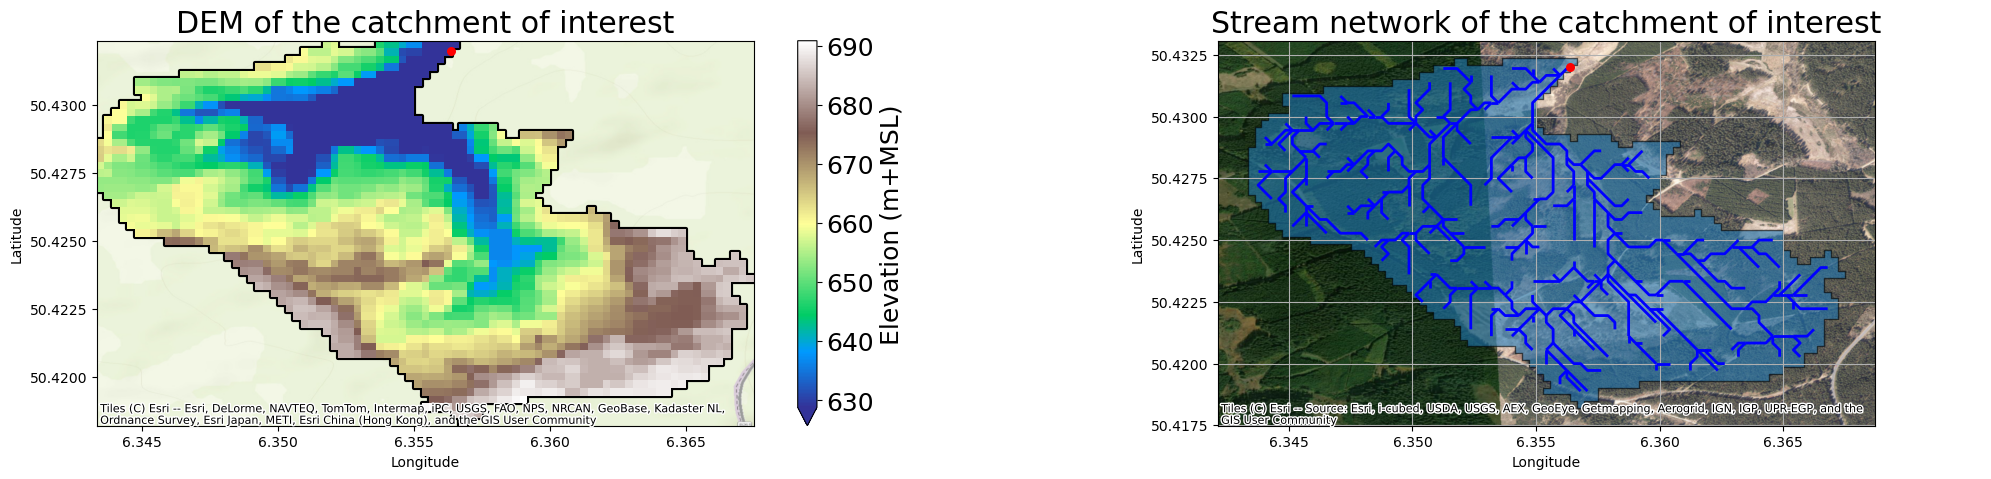

In [14]:
# Plot subbasin

src = rxr.open_rasterio(filled_dem_raster)

fig,(ax1, ax2) = plt.subplots(figsize=(25,5), ncols=2, nrows=1)
plt.rcParams['font.size'] = 18

gdf_catchment.boundary.plot(ax=ax1, edgecolor='k', linewidth=3, zorder=1)
src.plot(ax=ax1, cmap=plt.cm.terrain, cbar_kwargs={"label": "Elevation (m+MSL)"}, alpha=np.where(src <= 0, 0, 1), vmin=src.quantile(0.5))
gdf_outlet.plot(ax=ax1, marker='o', color='red', markersize=30, legend=True, zorder=2)
cx.add_basemap(ax=ax1, crs=4326, source=cx.providers.Esri.WorldTopoMap)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('DEM of the catchment of interest')

gdf_catchment.plot(ax=ax2, alpha=0.6, edgecolor='k', zorder=1)
gdf_streams.plot(ax=ax2, color='blue', linewidth=2, zorder=2)
gdf_outlet.plot(ax=ax2, marker='o', color='red', markersize=30, zorder=3)
cx.add_basemap(ax=ax2, crs=4326, source=cx.providers.Esri.WorldImagery)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Stream network of the catchment of interest')
ax2.grid(visible=None)

### Compute Maximum Length (L), Slope (i) and Catchment Area (A)

In [18]:
maximum_length_shp = os.path.join(temp_dir,'maximum_length.shp')
wbt.longest_flowpath(
    filled_dem_raster,
    catchment_raster, 
    maximum_length_shp)

0

A =  1.49  km2
Maximum travel length (L) =  2115.0 m
Average Slope (i) =  0.0355797


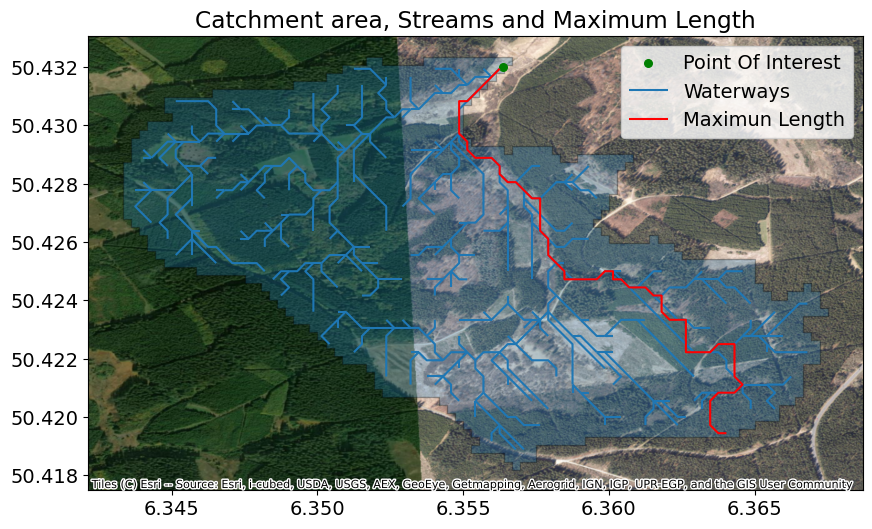

In [19]:
gdf_maxlen = gpd.read_file(maximum_length_shp)
gdf_maxlen = gdf_maxlen[gdf_maxlen['LENGTH']==gdf_maxlen['LENGTH'].max()].reset_index(drop=True)

# Plot catchment and longest flowpath

plt.rcParams['font.size'] = 14

fig,ax = plt.subplots(figsize=(10, 10))
plt.title("Catchment area, Streams and Maximum Length")
gdf_catchment.plot(ax=ax, alpha=0.3, edgecolor='k')
gdf_outlet.plot(ax=ax, marker='o', color='g', markersize=30, label="Point Of Interest")
# outlet.plot(ax=ax, marker='o', color='blue', markersize=30, label="Outlet")
gdf_streams.plot(ax=ax, label="Waterways")
gdf_maxlen.plot(ax=ax, color='red', label="Maximun Length")
cx.add_basemap(ax, crs=4326, source=cx.providers.Esri.WorldImagery)
ax.legend(loc="upper right", fontsize=14)

L = round((gdf_maxlen.to_crs(gdf_maxlen.estimate_utm_crs()).geometry.length),0)
i = round((gdf_maxlen['UP_ELEV'][0] - gdf_maxlen['DN_ELEV'][0]) / L, 7)

# Compute catchment area

catchment_utm = gdf_catchment.to_crs(gdf_catchment.estimate_utm_crs())
catchment_utm['area'] = catchment_utm.geometry.area / 10**6
A = round(catchment_utm['area'][0],2)

print('A = ', A, " km2")
print("Maximum travel length (L) = ", L[0], "m")
print("Average Slope (i) = ",i[0])

### Computation of the Time of Concentration


Computation of the __Time of Concentraction Tc (min)__ as the time for runoff to travel from the hydraulically most distant point in the drainage basin to the outlet or point of interest.

$$Tc = 0.02L^{0.77}S^{-0.385} $$

__L__ = maximum length of travel (m)

__S__ = slope, equal to H/L where H is the difference in elevation between the most remote point in the basin and the outlet


Computation of the __Time to Peak Tp (h)__ runoff unit hydrograph.

$$ Tp = 0.7 Tc $$

For small drainage basins of less than 15 km2, the time to peak is regarded as being
equal to the time of concentration.

$$ Tp = Tc $$


In [20]:
Tc = round(0.02*(L[0]**0.77)*i**-0.385 / 60, 2)[0]
print("Time of Concentration (Tc) = ",Tc,"h")

if A <= 15:
    Tp = Tc
else:
    Tp = round((0.7*Tc),2)
    
print("Time to Peak (Tp) = ",Tp,"h")

Time of Concentration (Tc) =  0.44 h
Time to Peak (Tp) =  0.44 h


### Compute the Curve Number (CN) and the Potential Maximum Retention (S) for the catchment

Data source: Jaafar, Hadi; Ahmad, Farah (2019): GCN250, global curve number datasets for hydrologic modeling and design. figshare. Dataset. https://doi.org/10.6084/m9.figshare.7756202.v1

$$ S = 254\frac{100}{CN-1} $$

In [21]:
# Read Global Curve Number file from url

gcn_condition_i = 'II' # 'I' is dry, 'II' is average, 'III' is wet
gcn_filename = f'GCN250_ARC{gcn_condition_i}'
tif_url = f'https://figshare.com/ndownloader/files/15377357/{gcn_filename}.tif'

# Download the GeoTIFF file to local folder
response = requests.get(tif_url)

# Check if the download was successful
if response.status_code == 200:
    # Save the GeoTIFF locally
    with open(os.path.join(temp_dir, f'{gcn_filename}.tif'), 'wb') as f:
        f.write(response.content)
    
else:
    print(f"Failed to download the GeoTIFF. Status code: {response.status_code}")

In [22]:
gdal.Warp(destNameOrDestDS = os.path.join(temp_dir, f'{gcn_filename}_catchment.tif'), # directory output
          srcDSOrSrcDSTab  = os.path.join(temp_dir, f'{gcn_filename}.tif'), # directoy input
          cutlineDSName    = os.path.join(temp_dir, 'catchment.geojson'), # vector file
          cropToCutline    = True,
          warpOptions = [ 'CUTLINE_ALL_TOUCHED=TRUE' ])

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x195cbb990> >

Warning 1: TIFFReadDirectory:Bogus "StripByteCounts" field, ignoring and calculating from imagelength


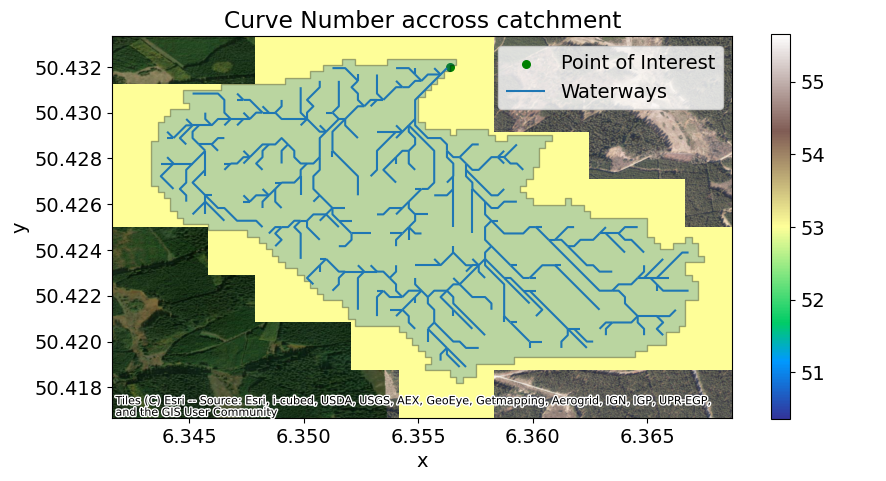

In [23]:
gcn_catchment = rxr.open_rasterio(os.path.join(temp_dir, f'{gcn_filename}_catchment.tif'), masked=True)

# Plot GCN for catchment

fig, ax = plt.subplots(figsize=(10, 5))
gcn_catchment.plot(cmap=plt.cm.terrain)
gdf_outlet.plot(ax=ax, marker='o', color='g', markersize=30, legend=True, label="Point of Interest")
# outlet.plot(ax=ax, marker='o', color='blue', markersize=30, label="Outlet")
gdf_catchment.plot(ax=ax, alpha=0.3, edgecolor='k')
gdf_streams.plot(ax=ax, label="Waterways")
ax.legend(loc="upper right", fontsize=14)
ax.set_title(label="Curve Number accross catchment")
cx.add_basemap(ax, crs=4326, source=cx.providers.Esri.WorldImagery)
# Adapt colorbar size, make map canvas slightly larger than raster bounding box

Text(0.5, 1.0, 'Curve Number Histogram')

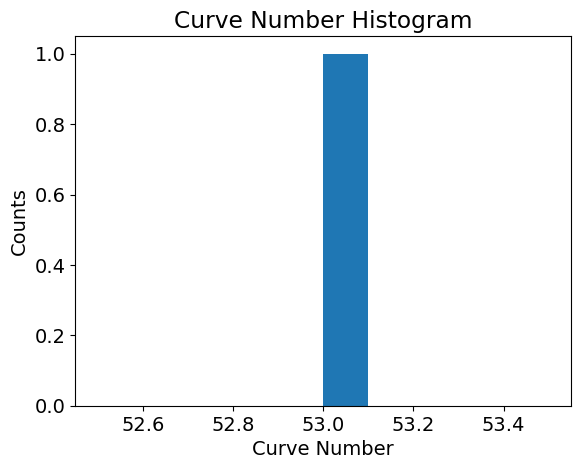

In [26]:
gcn_hist = np.array(gcn_catchment)
gcn_hist = gcn_hist[~np.isnan(gcn_hist)]

plt.hist(gcn_hist)
plt.xlabel('Curve Number')
plt.ylabel('Counts')
plt.title("Curve Number Histogram")

In [27]:
gcn_catchment = round(statistics.mean(gcn_hist),2)
S = round(254*(100/gcn_catchment-1),2)

print("Curve Number (CN) = ",gcn_catchment)
print("Potential Maximum Retention (S) = ",S,"mm")

Curve Number (CN) =  53.0
Potential Maximum Retention (S) =  225.25 mm


# Precipitation depth frequency analysis for the catchment

Possibility to input different types of data such as:

- Global dataset of precipitation frequency data: Generated by means of extreme value analysis (annual maxima) of ERA5 Reanalysis time-series of daily precipitation.
- Intensity-Duration-Frequency (IDF) or Depth-Duration-Frequency (DDF) curves (if available).


## ERA5 precipitation extreme value analysis

## Depth-Duration-Frequency curves (DDF)

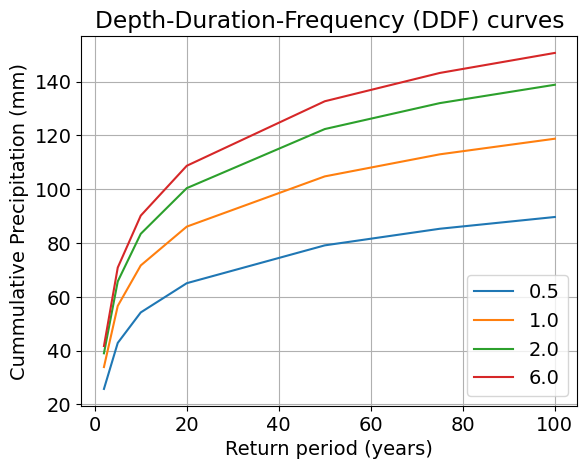

In [28]:
df_ddf_pr = pd.read_excel('/Users/aprida/Downloads/OHHVO.xlsx', sheet_name='DDF Curves Reduced', index_col='RP') # colnames as precipitation event duration (hours), precip values in mm.
df_ddf_pr = round(df_ddf_pr, 2)

fig,ax = plt.subplots()

df_ddf_pr.plot(ax=ax)
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Cummulative Precipitation (mm)')
ax.grid()
ax.set_title(label='Depth-Duration-Frequency (DDF) curves')
ax.legend()

# Computation of the design hydrographs at the outlet

This method envisages the split of an n-hour event into multiple small events of same duration. For each of the small events, an hydrograph is computed, using as input the time to peak (__Tp__), the peak runoff rate of the unit hydrograph (__qp__) and a normalized unit hydrograph. Subsequently, the hydrographs for all the small events are aggregated to compute the composite hydrograph at the outlet of the catchment of interest.

First, the excess precipitation (Q) is computed from precipitation depth (P) and the potential maximum retention (S).

$$ Q = \frac{(P-0.2S)^2}{P+ 0.8S} \ for \ P \ > 0.2S $$

Then, the peak runoff rate (__qp__) is computed:

$$ qp = 0.208\frac{AQ}{Tp}  $$

__A__ = area of drainage basin (km2)

__Q__ = excess precipitation (mm)

__qp__ = peak runoff rate (m3/s)

__Tp__ = time to peak runoff unit hydrograph (h)

Unit peak discharge (qp) =  0.7 cms
2
5
10
20
50
75
100
2
5
10
20
50
75
100
2
5
10
20
50
75
100
2
5
10
20
50
75
100


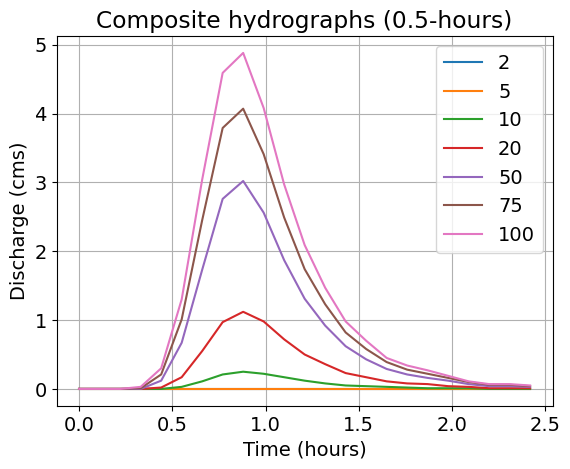

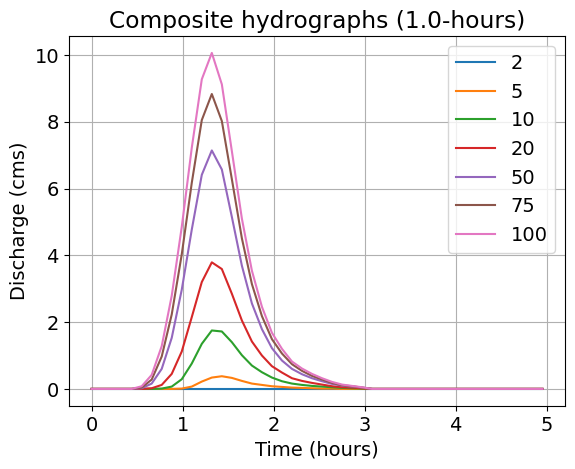

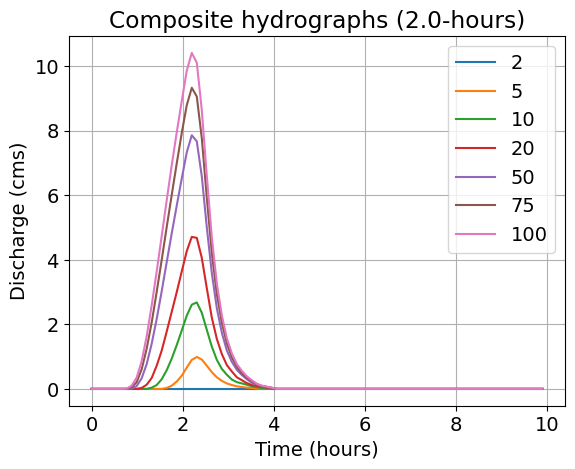

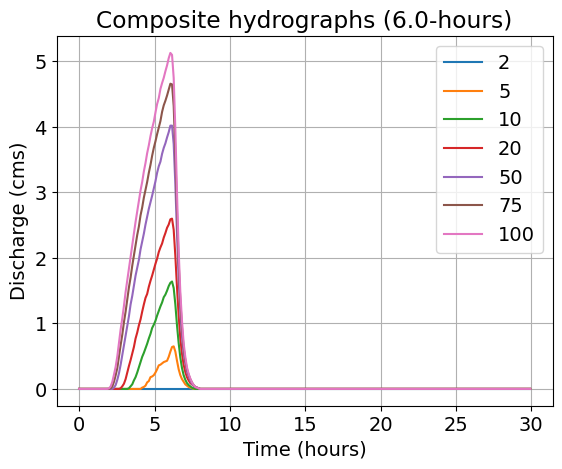

In [43]:
# Compute the peak runoff rate of the unit hydrograph (qp)

qp = 0.208*A*1/Tp
print('Unit peak discharge (qp) = ', round(qp,2), 'cms')

# Normalized unit hydrograph

df_uh_ref = pd.DataFrame({'t/Tp':[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25],
                                      'qt/qp': [0,0.12,0.43,0.83,1,0.88,0.66,0.45,0.32,0.22,0.15,0.105,0.075,0.053,0.036,0.026,0.018,0.012,0.009,0.006,0.004,0]})

interval = Tp/4 # h

rp_list = []
Q_list = []
d_list = []
    
for d in df_ddf_pr.columns:

    fig, ax = plt.subplots()

    for rp in df_ddf_pr.index:
        print(rp)
        precip = df_ddf_pr.loc[rp, d]
        df_comp_hydrograph = compute_comp_hydrograph(interval, d, precip)['comp_hydrograph']
        df_comp_hydrograph.plot(ax=ax)
        
        rp_list.append(rp)
        Q_list.append(round(df_comp_hydrograph.max(), 2))
        d_list.append(d)
        

    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Discharge (cms)')
    ax.grid()
    plt.legend(df_ddf_pr.index)
    plt.title(f'Composite hydrographs ({d}-hours)')
    
df_Qp = pd.DataFrame({'d': d_list, 'RP': rp_list, 'Qp': Q_list})

Text(0.5, 1.0, 'Peak discharge as function of event duration, per RP')

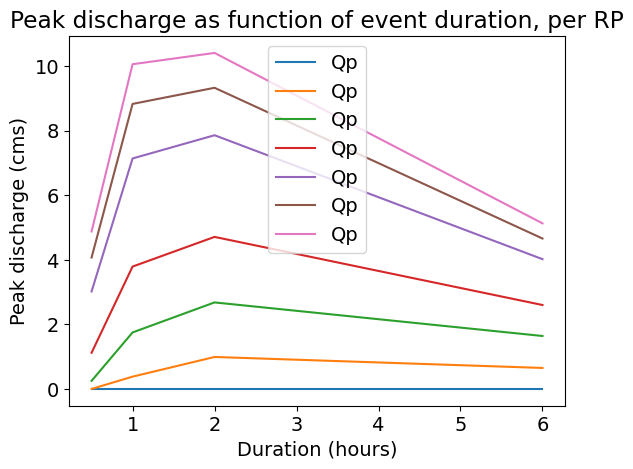

In [84]:
fig, ax = plt.subplots()

# loop through tickers and axes

for rp in df_Qp.RP.unique():
    
    df_plt = df_Qp[df_Qp['RP']==rp][['d', 'Qp']].set_index('d').plot(ax=ax, label=rp)
    df_plt.set_xlabel('Duration (hours)')
    df_plt.set_ylabel('Peak discharge (cms)')
    
plt.title('Peak discharge as function of event duration, per RP')